In [1]:
import os

import gym
import numpy as np
import pandas as pd
import seaborn as sns

from ray import init, rllib, tune, shutdown

In [2]:
from attack_simulator.agents import DEFENDERS
from attack_simulator.env import AttackSimulationEnv
from attack_simulator.graph import AttackGraph, SIZES

In [3]:
class AgentPolicy(rllib.policy.Policy):
    def __init__(self, observation_space, action_space, config):
        super().__init__(observation_space, action_space, config)
        agent_config = dict(
            input_dim=observation_space.shape[0],
            num_actions=action_space.n,
            random_seed=config["seed"],
            attack_graph=config["env_config"]["attack_graph"],
        )
        self._agent = DEFENDERS[config["agent_type"]](agent_config)

    def compute_actions(self, observations, *args, **kwargs):
        # FIXME: use a `numpy` array as a temporary workaround for
        #        https://github.com/ray-project/ray/issues/10100
        return np.array([self._agent.act(obs) for obs in observations]), [], {}

    def get_weights(self):
        return {}

    def set_weights(self, weights):
        pass


def template_agent(agent_type):
    default_config = rllib.agents.trainer.with_common_config(dict(agent_type=agent_type))
    return rllib.agents.trainer_template.build_trainer(
        name=agent_type,
        default_policy=AgentPolicy,
        default_config=default_config,
    )

In [4]:
from copy import deepcopy


class AttackSimAlphaZeroEnv(AttackSimulationEnv):
    def set_state(self, state):
        (
            self.simulation_time,
            self.ttc_remaining,
            self.attack_surface,
            self.attack_state,
            self.service_state,
            self._observation,
            self.rng,
            self.attacker,
        ) = deepcopy(state)

    def get_state(self):
        state = (
            self.simulation_time,
            self.ttc_remaining,
            self.attack_surface,
            self.attack_state,
            self.service_state,
            self._observation,
            self.rng,
            self.attacker,
        )
        return deepcopy(state)


class AlphaZeroWrapper(gym.Env):
    def __init__(self, config):
        self.env = config["env_class"](config)
        self.action_space = self.env.action_space
        assert isinstance(
            self.action_space, gym.spaces.Discrete
        ), "AlphaZero requires a Discrete action space"
        shape = (self.action_space.n,)
        self.observation_space = gym.spaces.Dict(
            dict(obs=self.env.observation_space, action_mask=gym.spaces.Box(0, 1, shape))
        )
        self.reward = 0
        self.mask = np.full(shape, 1, dtype="int8")

    def reset(self):
        self.reward = 0
        observation = self.env.reset()
        return dict(obs=observation, action_mask=self.mask)

    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        self.reward += reward
        reward = self.reward if done else 0
        return dict(obs=observation, action_mask=self.mask), reward, done, info

    def set_state(self, state):
        env_state, self.reward = state
        self.env.set_state(env_state)
        return dict(obs=self.env.observation, action_mask=self.mask)

    def get_state(self):
        return self.env.get_state(), self.reward

    def close(self):
        self.env.close()

    def render(self, mode=None):
        self.env.render(mode)

    def seed(self, seed=None):
        self.env.seed(seed)

In [5]:
# 'contrib/AlphaZero' does NOT appear to work without its custom dense model
from ray.rllib.contrib.alpha_zero.models.custom_torch_models import DenseModel

rllib.models.ModelCatalog.register_custom_model("alpha_zero_dense_model", DenseModel)

In [6]:
if os.path.isdir("/var/run/secrets/kubernetes.io"):  # inside k8s pod
    args = dict(address="auto")
else:
    # listen on all interfaces inside a container for port-forwarding to work
    dashboard_host = "0.0.0.0" if os.path.exists("/.dockerenv") else "127.0.0.1"
    args = dict(num_cpus=4, dashboard_host=dashboard_host)

# ALTERNATIVE: use the "Ray client" to connect to a remote cluster
# Unfortunately, JupyterNotebookReporter displays an object reference
# <IPython.core.display.HTML object> instead of content...
# --- --- ---
#
# from ray.util.client import worker
#
# worker.INITIAL_TIMEOUT_SEC = worker.MAX_TIMEOUT_SEC = 1
#
# ray_client_server = 'host.docker.internal' if os.path.exists("/.dockerenv") else '127.0.0.1'
# try:
#     init(address=f'ray://{ray_client_server}:10001')
# except Connection Error:
#     pass  # TODO: try something else...

In [7]:
agent_types = ["contrib/AlphaZero", "R2D2", "rule-based", "random"]
graphs = [AttackGraph(dict(graph_size=size)) for size in SIZES]
seeds = [0, 1, 2, 3, 6, 7, 11, 28, 42, 1337]
iterations = 10
rollouts = 10

common_config = dict(
    # log_level='DEBUG',
    framework="torch",
    env=AttackSimulationEnv,
    env_config=dict(attack_graph=tune.grid_search(graphs)),
    seed=tune.grid_search(seeds),
    # common evaluation settings
    evaluation_num_workers=1,
    evaluation_config=dict(
        explore=False,
        # workaround for a bug in RLLib (https://github.com/ray-project/ray/issues/17921)
        replay_sequence_length=-1,
    ),
    evaluation_num_episodes=rollouts,
)
train_and_eval_config = dict(
    common_config,
    num_workers=4,
    # evaluation at the end
    evaluation_interval=iterations,
)
eval_only_config = dict(
    common_config,
    # evaluation ONLY: avoid MultiGPU optimizer, set all relevant sizes to 0
    simple_optimizer=True,
    num_workers=0,
    train_batch_size=0,
    rollout_fragment_length=0,
    timesteps_per_iteration=0,
    # evaluation at the end
    evaluation_interval=1,
)

AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)
AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)
AttackGraph(en2720.yaml[medium-small], 9 services, 44 attack steps)
AttackGraph(en2720.yaml[medium], 13 services, 56 attack steps)
AttackGraph(en2720.yaml[large], 16 services, 62 attack steps)
AttackGraph(en2720.yaml[extra-large], 16 services, 65 attack steps)
AttackGraph(en2720.yaml[full], 18 services, 78 attack steps)


In [8]:
rename = {
    "config.env_config.agent_type": "Agent",
    "config.env_config.attack_graph": "graph",
    "evaluation.hist_stats.episode_reward": "returns",
    "evaluation.hist_stats.episode_lengths": "lengths",
}


def postprocess(results_df):
    df = results_df[rename.keys()].rename(columns=rename)
    df.dropna(inplace=True)  # remove `NaN` evaluation results from failed trials
    df["Graph size"] = df["graph"].apply(lambda g: g.num_attacks)
    del df["graph"]
    df["tuple"] = df.apply(lambda t: list(zip(t.returns, t.lengths)), axis="columns")
    del df["returns"]
    del df["lengths"]
    df = df.explode("tuple", ignore_index=True)
    df[["Returns", "Episode lengths"]] = df["tuple"].tolist()
    del df["tuple"]
    return df

In [9]:
def generate(savename):
    init(**args)

    frames = []
    for agent_type in agent_types:
        if agent_type in DEFENDERS:
            agent = template_agent(agent_type)
            config = dict(eval_only_config)
            stop = dict(training_iteration=0)
        else:
            agent = agent_type
            if agent_type == "contrib/AlphaZero":
                config = dict(
                    train_and_eval_config,
                    env=AlphaZeroWrapper,
                    model=dict(custom_model="alpha_zero_dense_model"),
                    rollout_fragment_length=32,
                    train_batch_size=640,
                    buffer_size=512,
                )
                config["env_config"].update(env_class=AttackSimAlphaZeroEnv)
            else:
                config = dict(train_and_eval_config, model=dict(use_lstm=True))

            stop = dict(training_iteration=iterations)  # TODO: additional stopping criteria?

        config["env_config"].update(agent_type=agent_type)
        results = tune.run(
            agent,
            config=config,
            stop=stop,
            max_failures=3,
            queue_trials=True,
            raise_on_failed_trial=False,
            progress_reporter=tune.JupyterNotebookReporter(overwrite=True),
        )
        frames.append(results.results_df)

    shutdown()
    results_df = pd.concat(frames, ignore_index=True)
    df = postprocess(results_df)
    df.to_csv(savename)
    return df

In [10]:
savename = "returns-tune-eval.csv"

df = generate(savename) if not os.path.exists(savename) else pd.read_csv(savename, index_col=0)

Trial name,status,loc,env_config/attack_graph,seed,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
random_AttackSimulationEnv_1b9f2_00000,TERMINATED,,"AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)",0,1,0.107162,0,nan,nan,nan,nan
random_AttackSimulationEnv_1b9f2_00001,TERMINATED,,"AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)",0,1,0.09641,0,nan,nan,nan,nan
random_AttackSimulationEnv_1b9f2_00002,TERMINATED,,"AttackGraph(en2720.yaml[medium-small], 9 services, 44 attack steps)",0,1,0.131263,0,nan,nan,nan,nan
random_AttackSimulationEnv_1b9f2_00003,TERMINATED,,"AttackGraph(en2720.yaml[medium], 13 services, 56 attack steps)",0,1,0.097198,0,nan,nan,nan,nan
random_AttackSimulationEnv_1b9f2_00004,TERMINATED,,"AttackGraph(en2720.yaml[large], 16 services, 62 attack steps)",0,1,0.159734,0,nan,nan,nan,nan
random_AttackSimulationEnv_1b9f2_00005,TERMINATED,,"AttackGraph(en2720.yaml[extra-large], 16 services, 65 attack steps)",0,1,0.15735,0,nan,nan,nan,nan
random_AttackSimulationEnv_1b9f2_00006,TERMINATED,,"AttackGraph(en2720.yaml[full], 18 services, 78 attack steps)",0,1,0.246701,0,nan,nan,nan,nan
random_AttackSimulationEnv_1b9f2_00007,TERMINATED,,"AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)",1,1,0.133039,0,nan,nan,nan,nan
random_AttackSimulationEnv_1b9f2_00008,TERMINATED,,"AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)",1,1,0.173662,0,nan,nan,nan,nan
random_AttackSimulationEnv_1b9f2_00009,TERMINATED,,"AttackGraph(en2720.yaml[medium-small], 9 services, 44 attack steps)",1,1,0.135895,0,nan,nan,nan,nan


2021-10-02 21:03:43,339	INFO tune.py:561 -- Total run time: 50.79 seconds (50.06 seconds for the tuning loop).


In [11]:
sns.set(style="darkgrid", rc={"figure.figsize": (12, 8)})

Text(0.5, 1.0, 'Returns vs Size (random attacker)')

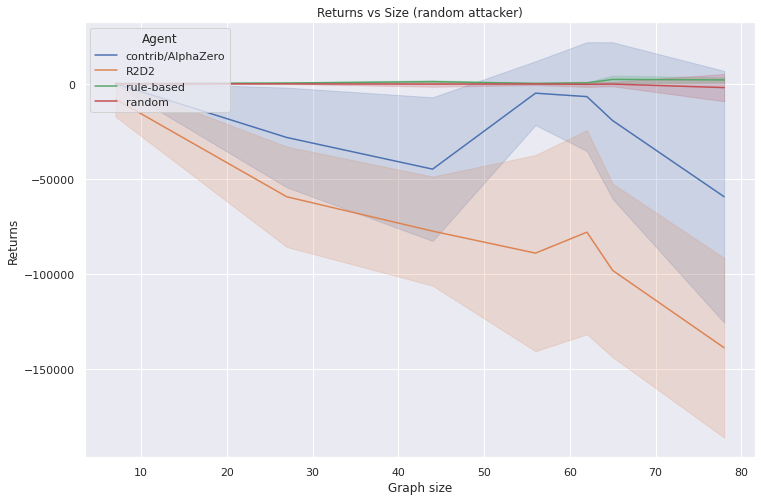

In [12]:
g = sns.lineplot(data=df, x="Graph size", y="Returns", hue="Agent", ci="sd")
g.legend(title="Agent", loc="upper left")
g.set_title("Returns vs Size (random attacker)")

Text(0.5, 1.0, 'Episode lengths vs Size (random attacker)')

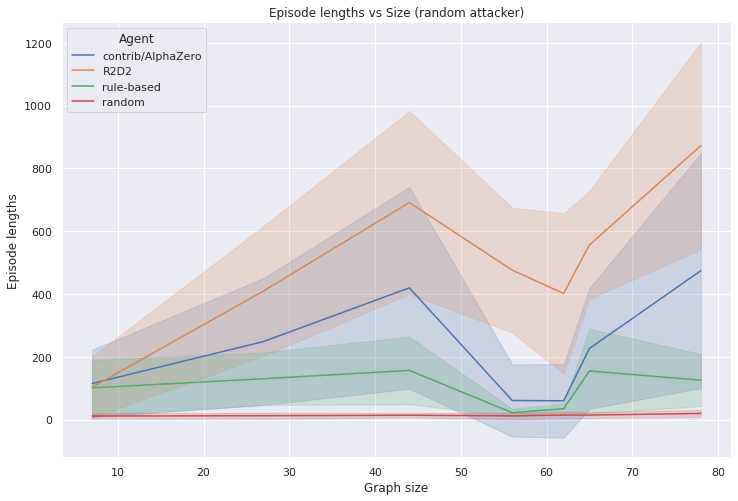

In [13]:
g = sns.lineplot(data=df, x="Graph size", y="Episode lengths", hue="Agent", ci="sd")
g.legend(title="Agent", loc="upper left")
g.set_title("Episode lengths vs Size (random attacker)")

In [14]:
# pd.set_option("display.max_columns", 32)
df.groupby("Agent").describe()

Graph size                                               \
                       count       mean        std  min   25%   50%   75%   
Agent                                                                       
R2D2                   701.0  48.369472  22.686853  7.0  27.0  56.0  65.0   
contrib/AlphaZero      858.0  48.920746  21.763731  7.0  27.0  56.0  62.0   
random                 700.0  48.428571  22.649012  7.0  27.0  56.0  65.0   
rule-based             700.0  48.428571  22.649012  7.0  27.0  56.0  65.0   

                        Returns                ...                     \
                    max   count          mean  ...       75%      max   
Agent                                          ...                      
R2D2               78.0   701.0 -78226.726106  ... -38452.00    650.0   
contrib/AlphaZero  78.0   858.0 -20118.904429  ...    418.50   8521.0   
random             78.0   700.0   -327.728571  ...    107.25    329.0   
rule-based         78.0   700.0   1029.797143  ...   1327.25  11668.0   

                  Episode lengths                                             \
                            count        mean         std  min    25%    50%   
Agent                                                                          
R2D2                        701.0  501.045649  323.401591  3.0  273.0  471.0   
contrib/AlphaZero           858.0  201.668998  259.983749  3.0   30.0   78.0   
random                      700.0   14.314286   10.071054  3.0    7.0   12.0   
rule-based                  700.0  103.852857   99.686948  6.0   35.0   75.0   

                                   
                      75%     max  
Agent                              
R2D2               684.00  2036.0  
contrib/AlphaZero  285.75  1594.0  
random              18.00    69.0  
rule-based         138.00   775.0  

[4 rows x 24 columns]